Collaborated with Rishi Mule

# Problem 2

### MNIST K-Means

In [1]:
import numpy as np
import pandas as pd
import struct
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import tqdm

In [2]:
#Load train images 

with open('train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_train = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_train = X_train.reshape((size, nrows*ncols))
    
print(X_train.shape)

(60000, 784)


In [3]:
#Load train labels

with open('train-labels.idx1-ubyte', 'rb') as f:
    magic, size = struct.unpack(">2i", f.read(8))
    y_train = struct.unpack('>%dB' % size, f.read())
    y_train = np.array(y_train, np.int32)

    
print(y_train.shape)

(60000,)


In [4]:

with open('t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_test = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_test = X_test.reshape((size, nrows*ncols))
    
print(X_test.shape)


(10000, 784)


In [5]:
#Load test labels

with open('t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">2i", f.read(8))
    y_test = struct.unpack('>%dB' % size, f.read())
    y_test = np.array(y_test, np.int32)
    
print(y_test.shape)

(10000,)


In [6]:
X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

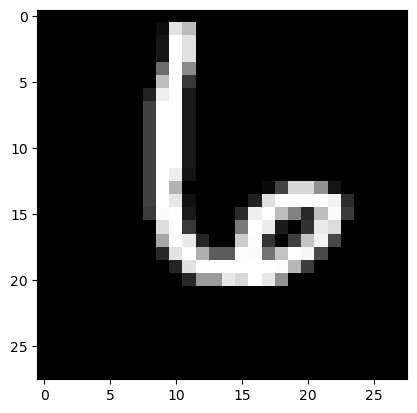

label: 6


In [7]:
pixels = X_test[156].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

print('label:', y_test[156])

In [8]:
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# Select subset of X_train and Y_train
X_train_sample = []
y_train_sample = []

for i in np.unique(y_train):
    x = X_train[y_train == i]
    y = y_train[y_train == i]
    
    indices = np.random.randint(low = 0,high = len(x), size = 1000)
    
    x = x[indices]
    y = y[indices]
    
    X_train_sample.extend(x)
    y_train_sample.extend(y)
    
X_train = np.array(X_train_sample)
y_train = np.array(y_train_sample)

In [10]:
#Normalize Features

# Shift-and-scale normalization (Min - Max Scaling)
# Subtract min from each value and divide by new max

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train) 
X_test_scaled = min_max_scaler.transform(X_test)    #test data is scaled using train data

In [11]:
class KMeans:
    
    def __init__(self, K = 10, max_iterations = 100, is_labelled = False):
        self.K = K
        self.max_iterations = max_iterations
        
        self.clusters = [[] for _ in range(self.K)]
        self.is_labelled = is_labelled
        self.cluster_point_labels = [[] for _ in range(self.K)]
        
    def similarity_matrix(self, X, Y, similarity_metric):
        if similarity_metric == 'euclidean':
            X_2 = np.square(X)
            X_2 = X_2.sum(axis=1).reshape(1, X.shape[0])
            X_2 = X_2 * np.ones(shape=(Y.shape[0], X.shape[0]), dtype=int)
            Y_2 = np.square(Y)
            Y_2 = Y_2.sum(axis=1).reshape(Y.shape[0], 1)
            Y_2 = Y_2 * np.ones(shape=(1, X.shape[0]), dtype=int)

            similarity_matrix = np.sqrt(Y_2 + X_2 - 2 * np.matmul(Y, X.T))

        return similarity_matrix

    def predict_Kmeans(self, X):
        self.X = X
        self.centroids = np.empty((len(self.clusters), X.shape[0]))
        self.no_samples, self.no_features = X.shape
        self.initialize_centroids()
        total_iterations_executed = 0
        for i in range(self.max_iterations):
            # update clusters - estep
            similarity_matrix = self.similarity_matrix(self.centroids, X, 'euclidean')
            self.clusters, self.cluster_point_labels = self.e_step(similarity_matrix)
            # update centroids - mstep
            curr_centroids = self.m_step(similarity_matrix)
            # check if clusters changed
            total_iterations_executed = i
            if np.array_equal(curr_centroids, self.centroids):
                break
            else:
                self.centroids = curr_centroids
        print("total iterations executed : ",i)
        return self.clusters, self.cluster_point_labels
    
    def set_labels(self,y):
        self.y = y
    
    def initialize_centroids(self):
        # get random K indexes for K centroidss
        random_indexes = np.random.choice(self.no_samples, self.K, replace = False)
        self.centroids = self.X[random_indexes]
        
#     def e_step(self, similarity_matrix):
#         #assign points to centroids
#         min_indices = np.argmin(similarity_matrix, axis=1)

#         clusters = [[] for _ in range(similarity_matrix.shape[1])]
#         for row_index, min_index in enumerate(min_indices):
#             clusters[min_index].append(self.X[row_index])
#         return clusters
    
    def e_step(self, similarity_matrix):
        # assign points to centroids along with labels
        min_indices = np.argmin(similarity_matrix, axis=1)
        labels = [[] for _ in range(similarity_matrix.shape[1])]
        clusters = [[] for _ in range(similarity_matrix.shape[1])]
        for row_index, min_index in enumerate(min_indices):
            clusters[min_index].append(self.X[row_index])
            if self.is_labelled:
                labels[min_index].append(self.y[row_index])
        return clusters, labels
        
    def m_step(self,similarity_matrix):
        #modify centroids
        centroid_array = np.empty((len(self.clusters), self.X.shape[1]))
        for i, group in enumerate(self.clusters):
            mean_of_group = np.mean(group, axis=0)
            centroid_array[i] = mean_of_group

        return centroid_array
    
    def purity_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        purity_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Get the majority class in the cluster
            majority_class = class_counts.most_common(1)[0][0]

            # Add the proportion of the majority class to purity_sum
            purity_sum += class_counts[majority_class]

        purity = purity_sum / total_samples
        return purity
    
    def gini_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        gini_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Calculate Gini impurity for the cluster
            cluster_size = sum(class_counts.values())
            impurity = 1.0
            for class_count in class_counts.values():
                proportion = class_count / cluster_size
                impurity -= proportion ** 2

            # Weighted Gini impurity based on cluster size
            gini_sum += impurity * (cluster_size / total_samples)

        return gini_sum


In [12]:
kmeans = KMeans(is_labelled=True)

In [13]:
kmeans.set_labels(y_train)

In [14]:
clusters, labels = kmeans.predict_Kmeans(X_train)
purity = kmeans.purity_index()
print("Purity Index:", purity)
gini = kmeans.gini_index()
print("Gini Index:", gini)

total iterations executed :  34
Purity Index: 0.63
Gini Index: 0.4965112559537707


In [15]:
clusters, labels = kmeans.predict_Kmeans(X_train)

purity = kmeans.purity_index()
print("Purity Index:", purity)
gini = kmeans.gini_index()
print("Gini Index:", gini)

total iterations executed :  46
Purity Index: 0.5843
Gini Index: 0.5448485677352926


In [16]:
kmeans = KMeans(K=5,is_labelled=True)
kmeans.set_labels(y_train)
clusters, labels = kmeans.predict_Kmeans(X_train)
purity = kmeans.purity_index()
print("Purity Index:", purity)
gini = kmeans.gini_index()
print("Gini Index:", gini)

total iterations executed :  30
Purity Index: 0.437
Gini Index: 0.6652088876150224


In [17]:
kmeans = KMeans(K=20,is_labelled=True)
kmeans.set_labels(y_train)
clusters, labels = kmeans.predict_Kmeans(X_train)
purity = kmeans.purity_index()
print("Purity Index:", purity)
gini = kmeans.gini_index()
print("Gini Index:", gini)

total iterations executed :  75
Purity Index: 0.7133
Gini Index: 0.3954894261096493


### K-Means 20NG

In [55]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [66]:
class KMeans:
    
    def __init__(self, K = 10, max_iterations = 100, is_labelled = False):
        self.K = K
        self.max_iterations = max_iterations
        
        self.clusters = [[] for _ in range(self.K)]
        self.is_labelled = is_labelled
        self.cluster_point_labels = [[] for _ in range(self.K)]
        
    def similarity_matrix(self, X, Y, similarity_metric):
        if similarity_metric == 'euclidean':
            X_2 = np.square(X)
            X_2 = X_2.sum(axis=1).reshape(1, X.shape[0])
            X_2 = X_2 * np.ones(shape=(Y.shape[0], X.shape[0]), dtype=int)
            Y_2 = np.square(Y)
            Y_2 = Y_2.sum(axis=1).reshape(Y.shape[0], 1)
            Y_2 = Y_2 * np.ones(shape=(1, X.shape[0]), dtype=int)

            similarity_matrix = np.sqrt(Y_2 + X_2 - 2 * np.matmul(Y, X.T))
        elif similarity_metric == 'cosine':
            X_2 = np.square(X)
            X_2 = X_2.sum(axis = 1).reshape(1, X.shape[0])
            X_2 = np.sqrt(X_2)
            X_2 = X_2 * np.ones(shape = (Y.shape[0],X.shape[0]), dtype = int)

            Y_2 = np.square(Y)
            Y_2 = Y_2.sum(axis = 1).reshape(Y.shape[0],1)
            Y_2 = np.sqrt(Y_2)
            Y_2 = Y_2 * np.ones(shape = (1,X.shape[0]), dtype = int)

            similarity_matrix = np.matmul(Y, X.T) / (X_2 * Y_2)
               
        

        return similarity_matrix

    def predict_Kmeans(self, X):
        self.X = X
        self.centroids = np.empty((len(self.clusters), X.shape[0]))
        self.no_samples, self.no_features = X.shape
        self.initialize_centroids()
        total_iterations_executed = 0
        for i in range(self.max_iterations):
            # update clusters - estep
            similarity_matrix = self.similarity_matrix(self.centroids, X, 'euclidean')
            self.clusters, self.cluster_point_labels = self.e_step(similarity_matrix)
            # update centroids - mstep
            curr_centroids = self.m_step(similarity_matrix)
            # check if clusters changed
            total_iterations_executed = i
            if np.array_equal(curr_centroids, self.centroids):
                break
            else:
                self.centroids = curr_centroids
        print("total iterations executed : ",i)
        return self.clusters, self.cluster_point_labels
    
    def set_labels(self,y):
        self.y = y
    
    def initialize_centroids(self):
        # get random K indexes for K centroidss
        random_indexes = np.random.choice(self.no_samples, self.K, replace = False)
        self.centroids = self.X[random_indexes]
        
#     def e_step(self, similarity_matrix):
#         #assign points to centroids
#         min_indices = np.argmin(similarity_matrix, axis=1)

#         clusters = [[] for _ in range(similarity_matrix.shape[1])]
#         for row_index, min_index in enumerate(min_indices):
#             clusters[min_index].append(self.X[row_index])
#         return clusters
    
    def e_step(self, similarity_matrix):
        # assign points to centroids along with labels
        min_indices = np.argmin(similarity_matrix, axis=1)
        labels = [[] for _ in range(similarity_matrix.shape[1])]
        clusters = [[] for _ in range(similarity_matrix.shape[1])]
        for row_index, min_index in enumerate(min_indices):
            clusters[min_index].append(self.X[row_index])
            if self.is_labelled:
                labels[min_index].append(self.y[row_index])
        return clusters, labels
        
    def m_step(self,similarity_matrix):
        #modify centroids
        centroid_array = np.empty((len(self.clusters), self.X.shape[1]))
        for i, group in enumerate(self.clusters):
            mean_of_group = np.mean(group, axis=0)
            centroid_array[i] = mean_of_group

        return centroid_array
    
    def purity_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        purity_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Get the majority class in the cluster
            majority_class = class_counts.most_common(1)[0][0]

            # Add the proportion of the majority class to purity_sum
            purity_sum += class_counts[majority_class]

        purity = purity_sum / total_samples
        return purity
    
    def gini_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        gini_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Calculate Gini impurity for the cluster
            cluster_size = sum(class_counts.values())
            impurity = 1.0
            for class_count in class_counts.values():
                proportion = class_count / cluster_size
                impurity -= proportion ** 2

            # Weighted Gini impurity based on cluster size
            gini_sum += impurity * (cluster_size / total_samples)

        return gini_sum


In [67]:

# Load 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_data.data
y = newsgroups_data.target


# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(documents)

# Normalize the TF-IDF matrix
tfidf_matrix_normalized = normalize(tfidf_matrix, norm='l2', axis=1)

# Convert the normalized TF-IDF matrix to a numpy array
X = tfidf_matrix_normalized.toarray()


In [68]:
print(y)

[10  3 17 ...  3  1  7]


In [69]:


# Apply K-means clustering
kmeans = KMeans(K=20, max_iterations=100, is_labelled=True)
kmeans.set_labels(y)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)

total iterations executed :  99
Cluster 1 - Size: 0
Cluster 2 - Size: 18846
Cluster 3 - Size: 0
Cluster 4 - Size: 0
Cluster 5 - Size: 0
Cluster 6 - Size: 0
Cluster 7 - Size: 0
Cluster 8 - Size: 0
Cluster 9 - Size: 0
Cluster 10 - Size: 0
Cluster 11 - Size: 0
Cluster 12 - Size: 0
Cluster 13 - Size: 0
Cluster 14 - Size: 0
Cluster 15 - Size: 0
Cluster 16 - Size: 0
Cluster 17 - Size: 0
Cluster 18 - Size: 0
Cluster 19 - Size: 0
Cluster 20 - Size: 0
Purity Index: 0.05300859598853868
Gini Index: 0.9494968400017528


In [70]:
# Half Clusters

# Apply K-means clustering
kmeans = KMeans(K=10, max_iterations=100, is_labelled=True)
kmeans.set_labels(y)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)

total iterations executed :  24
Cluster 1 - Size: 7293
Cluster 2 - Size: 444
Cluster 3 - Size: 1291
Cluster 4 - Size: 1975
Cluster 5 - Size: 3370
Cluster 6 - Size: 754
Cluster 7 - Size: 72
Cluster 8 - Size: 710
Cluster 9 - Size: 1851
Cluster 10 - Size: 1086
Purity Index: 0.2618592804839223
Gini Index: 0.8164732749772327


In [71]:
# double k
# Apply K-means clustering
kmeans = KMeans(K=40, max_iterations=100, is_labelled=True)
kmeans.set_labels(y)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)

total iterations executed :  99
Cluster 1 - Size: 0
Cluster 2 - Size: 18846
Cluster 3 - Size: 0
Cluster 4 - Size: 0
Cluster 5 - Size: 0
Cluster 6 - Size: 0
Cluster 7 - Size: 0
Cluster 8 - Size: 0
Cluster 9 - Size: 0
Cluster 10 - Size: 0
Cluster 11 - Size: 0
Cluster 12 - Size: 0
Cluster 13 - Size: 0
Cluster 14 - Size: 0
Cluster 15 - Size: 0
Cluster 16 - Size: 0
Cluster 17 - Size: 0
Cluster 18 - Size: 0
Cluster 19 - Size: 0
Cluster 20 - Size: 0
Cluster 21 - Size: 0
Cluster 22 - Size: 0
Cluster 23 - Size: 0
Cluster 24 - Size: 0
Cluster 25 - Size: 0
Cluster 26 - Size: 0
Cluster 27 - Size: 0
Cluster 28 - Size: 0
Cluster 29 - Size: 0
Cluster 30 - Size: 0
Cluster 31 - Size: 0
Cluster 32 - Size: 0
Cluster 33 - Size: 0
Cluster 34 - Size: 0
Cluster 35 - Size: 0
Cluster 36 - Size: 0
Cluster 37 - Size: 0
Cluster 38 - Size: 0
Cluster 39 - Size: 0
Cluster 40 - Size: 0
Purity Index: 0.05300859598853868
Gini Index: 0.9494968400017528


### K-Means Fashion

In [25]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter


In [27]:

# Load Fashion MNIST dataset from TensorFlow
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images and normalize pixel values
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(float) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(float) / 255.0

# Preprocess data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components based on your requirements
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Normalize the PCA-transformed data
X_train_normalized = normalize(X_train_pca, norm='l2', axis=1)
X_test_normalized = normalize(X_test_pca, norm='l2', axis=1)


In [28]:
X_train_normalized[0]

array([-0.02812788,  0.73259606, -0.4544817 ,  0.11625873, -0.23307289,
        0.03696296, -0.00361969, -0.18919268, -0.1403924 ,  0.07647975,
        0.0223059 ,  0.07571167, -0.07071129,  0.0734492 ,  0.05500344,
        0.00451487,  0.01779265,  0.04335456,  0.05995131,  0.04816673,
       -0.0223154 , -0.02595638,  0.04002826,  0.01437885, -0.09645387,
       -0.07181831,  0.02796755, -0.0083481 ,  0.07779764, -0.13477538,
        0.0303804 ,  0.08609606,  0.10729312, -0.00396701, -0.0061413 ,
       -0.02699732, -0.07437869, -0.02354206,  0.05005539, -0.00084133,
        0.05764439, -0.01849225,  0.03046031,  0.08952453,  0.06717979,
       -0.07062027,  0.01372438,  0.00449787,  0.05418787, -0.02490683])

In [29]:
class KMeans:
    
    def __init__(self, K = 10, max_iterations = 100, is_labelled = False):
        self.K = K
        self.max_iterations = max_iterations
        
        self.clusters = [[] for _ in range(self.K)]
        self.is_labelled = is_labelled
        self.cluster_point_labels = [[] for _ in range(self.K)]
        
    def similarity_matrix(self, X, Y, similarity_metric):
        if similarity_metric == 'euclidean':
            X_2 = np.square(X)
            X_2 = X_2.sum(axis=1).reshape(1, X.shape[0])
            X_2 = X_2 * np.ones(shape=(Y.shape[0], X.shape[0]), dtype=int)
            Y_2 = np.square(Y)
            Y_2 = Y_2.sum(axis=1).reshape(Y.shape[0], 1)
            Y_2 = Y_2 * np.ones(shape=(1, X.shape[0]), dtype=int)

            similarity_matrix = np.sqrt(Y_2 + X_2 - 2 * np.matmul(Y, X.T))

        return similarity_matrix

    def predict_Kmeans(self, X):
        self.X = X
        self.centroids = np.empty((len(self.clusters), X.shape[0]))
        self.no_samples, self.no_features = X.shape
        self.initialize_centroids()
        total_iterations_executed = 0
        for i in range(self.max_iterations):
            # update clusters - estep
            similarity_matrix = self.similarity_matrix(self.centroids, X, 'euclidean')
            self.clusters, self.cluster_point_labels = self.e_step(similarity_matrix)
            # update centroids - mstep
            curr_centroids = self.m_step(similarity_matrix)
            # check if clusters changed
            total_iterations_executed = i
            if np.array_equal(curr_centroids, self.centroids):
                break
            else:
                self.centroids = curr_centroids
        print("total iterations executed : ",i)
        return self.clusters, self.cluster_point_labels
    
    def set_labels(self,y):
        self.y = y
    
    def initialize_centroids(self):
        # get random K indexes for K centroidss
        random_indexes = np.random.choice(self.no_samples, self.K, replace = False)
        self.centroids = self.X[random_indexes]
        
#     def e_step(self, similarity_matrix):
#         #assign points to centroids
#         min_indices = np.argmin(similarity_matrix, axis=1)

#         clusters = [[] for _ in range(similarity_matrix.shape[1])]
#         for row_index, min_index in enumerate(min_indices):
#             clusters[min_index].append(self.X[row_index])
#         return clusters
    
    def e_step(self, similarity_matrix):
        # assign points to centroids along with labels
        min_indices = np.argmin(similarity_matrix, axis=1)
        labels = [[] for _ in range(similarity_matrix.shape[1])]
        clusters = [[] for _ in range(similarity_matrix.shape[1])]
        for row_index, min_index in enumerate(min_indices):
            clusters[min_index].append(self.X[row_index])
            if self.is_labelled:
                labels[min_index].append(self.y[row_index])
        return clusters, labels
        
    def m_step(self,similarity_matrix):
        #modify centroids
        centroid_array = np.empty((len(self.clusters), self.X.shape[1]))
        for i, group in enumerate(self.clusters):
            mean_of_group = np.mean(group, axis=0)
            centroid_array[i] = mean_of_group

        return centroid_array
    
    def purity_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        purity_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Get the majority class in the cluster
            majority_class = class_counts.most_common(1)[0][0]

            # Add the proportion of the majority class to purity_sum
            purity_sum += class_counts[majority_class]

        purity = purity_sum / total_samples
        return purity
    
    def gini_index(self):
        total_samples = len(self.y) if self.is_labelled else len(self.X)

        gini_sum = 0.0
        for cluster_labels in self.cluster_point_labels:
            if not cluster_labels:
                continue

            # Count occurrences of each class in the cluster
            class_counts = Counter(cluster_labels)

            # Calculate Gini impurity for the cluster
            cluster_size = sum(class_counts.values())
            impurity = 1.0
            for class_count in class_counts.values():
                proportion = class_count / cluster_size
                impurity -= proportion ** 2

            # Weighted Gini impurity based on cluster size
            gini_sum += impurity * (cluster_size / total_samples)

        return gini_sum


In [30]:

# Apply K-means clustering

# Instantiate KMeans class
kmeans = KMeans(K=10, max_iterations=100, is_labelled=True)

# Set labels
kmeans.set_labels(y_train)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)


total iterations executed :  29
Cluster 1 - Size: 7268
Cluster 2 - Size: 3656
Cluster 3 - Size: 450
Cluster 4 - Size: 1018
Cluster 5 - Size: 1098
Cluster 6 - Size: 1798
Cluster 7 - Size: 675
Cluster 8 - Size: 517
Cluster 9 - Size: 774
Cluster 10 - Size: 1592
Purity Index: 0.03521666666666667
Gini Index: 0.2825031692723965


In [32]:
# Apply K-means clustering
# half k

# Instantiate KMeans class
kmeans = KMeans(K=5, max_iterations=100, is_labelled=True)

# Set labels
kmeans.set_labels(y_train)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)


total iterations executed :  56
Cluster 1 - Size: 1634
Cluster 2 - Size: 9763
Cluster 3 - Size: 4229
Cluster 4 - Size: 753
Cluster 5 - Size: 2467
Purity Index: 0.03398333333333333
Gini Index: 0.2825820054511114


In [37]:

# # Visualize the first two principal components with cluster labels
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', s=5, alpha=0.5)
# plt.title('Fashion MNIST Clusters')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()


In [38]:
# Apply K-means clustering
# double k
# Instantiate KMeans class
kmeans = KMeans(K=20, max_iterations=100, is_labelled=True)

# Set labels
kmeans.set_labels(y_train)
# Perform clustering and get purity and Gini index
clusters, labels = kmeans.predict_Kmeans(X)
# Print some information about the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1} - Size: {len(cluster)}")
        
purity = kmeans.purity_index()
gini = kmeans.gini_index()

print("Purity Index:", purity)
print("Gini Index:", gini)


total iterations executed :  34
Cluster 1 - Size: 1
Cluster 2 - Size: 1
Cluster 3 - Size: 1
Cluster 4 - Size: 1
Cluster 5 - Size: 1
Cluster 6 - Size: 1
Cluster 7 - Size: 1
Cluster 8 - Size: 1
Cluster 9 - Size: 1
Cluster 10 - Size: 248
Cluster 11 - Size: 13389
Cluster 12 - Size: 4353
Cluster 13 - Size: 1
Cluster 14 - Size: 1
Cluster 15 - Size: 840
Cluster 16 - Size: 1
Cluster 17 - Size: 1
Cluster 18 - Size: 1
Cluster 19 - Size: 1
Cluster 20 - Size: 1
Purity Index: 0.033633333333333335
Gini Index: 0.28237393869817196


# Problem 4

In [39]:
import numpy as np
import random
from scipy.stats import binom


In [92]:

def coin_em(data, pi, p, max_iter=100, tolerance=1e-6):
    N = len(data)
    n_coins = len(pi)

    
    for _ in range(max_iter):
        print("Iteration ", _ , p, pi)
        
        # E-Step 
        # Calculate responsibilities for all 3 coins
        responsibilities = np.zeros((N, n_coins))
        for i in range(N):
            for j in range(n_coins):
                responsibilities[i, j] = pi[j] * p[j]**np.sum(data[i]) * (1 - p[j])**(len(data[i]) - np.sum(data[i]))
        
        # Normalize responsibilities to form posteriors
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        # print(responsibilities)
        
        # M-Step
        # Update pi's and p's
        pi_new = responsibilities.mean(axis=0)
        p_new = np.zeros(n_coins)
        for j in range(n_coins):
            p_new[j] = np.sum([responsibilities[i, j] * np.sum(data[i]) for i in range(N)]) / np.sum([responsibilities[i, j] * len(data[i]) for i in range(N)])
        
        # Check for convergence and break loop when it occurs
        diff = np.abs(pi_new - pi).sum() + np.abs(p_new - p).sum()
        if diff < tolerance:
            break
        
        pi = pi_new
        p = p_new
    
    return pi, p


In [93]:
import numpy as np

def read_rolls_from_file(file_path):
    rolls_data = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Assuming each line contains space-separated values representing a session
            session_outcomes = [int(value) for value in line.strip().split()]
            rolls_data.append(session_outcomes)
    
    return np.array(rolls_data)

# Specify the path to your text file
file_path = 'coin_flips_outcome.txt'

# Read rolls data from the file
rolls = read_rolls_from_file(file_path)

In [94]:

pi = np.array([0.2,  0.5,  0.3])
p = np.array([0.2,  0.5,  0.8])

final_pi, final_p = coin_em(rolls, pi, p)



Iteration  0 [0.2 0.5 0.8] [0.2 0.5 0.3]
Iteration  1 [0.19928126 0.53033407 0.82350788] [0.22836962 0.43644241 0.33518797]
Iteration  2 [0.20769411 0.55206162 0.83976942] [0.24942948 0.44875809 0.30181243]
Iteration  3 [0.21488256 0.57011918 0.86187594] [0.26416137 0.47287775 0.26296088]
Iteration  4 [0.22069375 0.58494535 0.88887598] [0.2756441  0.49911222 0.22524368]
Iteration  5 [0.22543762 0.59583932 0.91388597] [0.28491328 0.5179677  0.19711902]
Iteration  6 [0.22922016 0.60231378 0.92714743] [0.29224274 0.52390894 0.18384832]
Iteration  7 [0.23200225 0.60567074 0.93077144] [0.29756612 0.52242706 0.18000682]
Iteration  8 [0.23387206 0.60746823 0.93148619] [0.30110122 0.51982837 0.17907042]
Iteration  9 [0.2350576  0.60849532 0.93163831] [0.30332812 0.51786916 0.17880271]
Iteration  10 [0.23578823 0.60910564 0.93168331] [0.3046971  0.51660766 0.17869524]
Iteration  11 [0.23623351 0.60947355 0.93170273] [0.30553088 0.51582979 0.17863934]
Iteration  12 [0.23650375 0.6096962  0.93171

In [95]:

# Print the final estimated parameters
print("Final estimated selection probabilities:", final_pi)
print("Final estimated bias:", final_p)

Final estimated selection probabilities: [0.3068133  0.51462898 0.17855772]
Final estimated bias: [0.2369183  0.61003753 0.93172852]


# Problem 3

Estimated Parameters:
Pi: 0.33477414797919625
Mean 1: [2.99400411 3.05211181]
Covariance 1:
[[1.01002325 0.02721443]
 [0.02721443 2.93792215]]
Mean 2: [7.01308197 3.98309628]
Covariance 2:
[[0.97493021 0.49756753]
 [0.49756753 1.00122471]]


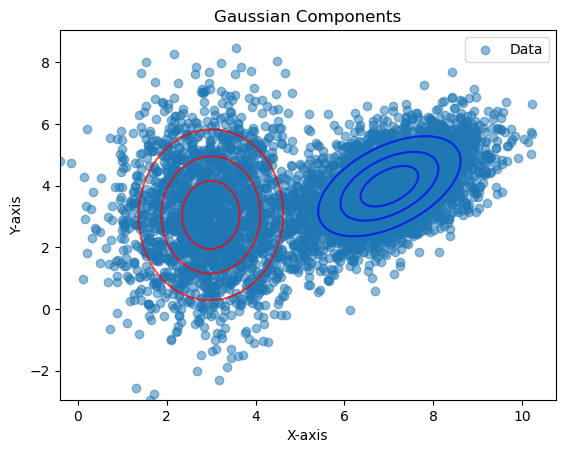

In [48]:
def read_data_from_file(file_path):
    # Read data from the text file
    data = np.loadtxt(file_path)
    return data

def initialize_parameters():
    # Initialize parameters randomly
    pi = random.random()  # Mixing coefficient
    mean1 = np.random.rand(2) * 10  # Random mean vector
    cov1 = np.random.rand(2, 2) * 5  # Random covariance matrix
    mean2 = np.random.rand(2) * 10
    cov2 = np.random.rand(2, 2) * 5

    return pi, mean1, cov1, mean2, cov2

def expectation(data, pi, mean1, cov1, mean2, cov2):
    # E-step: Calculate responsibilities
    pdf1 = pi * gaussian_pdf(data, mean1, cov1)
    pdf2 = (1 - pi) * gaussian_pdf(data, mean2, cov2)
    responsibilities = pdf1 / (pdf1 + pdf2)
    return responsibilities

def gaussian_pdf(x, mean, cov):
    # Calculate the probability density function for multivariate Gaussian
    n = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1 / np.sqrt((2 * np.pi) ** n * det_cov)
    diff = x - mean
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    pdf = norm_const * np.exp(exponent)
    return pdf


def maximization(data, responsibilities):
    # M-step: Update parameters
    total_weight = np.sum(responsibilities)

    # Update mixing coefficient
    pi = total_weight / len(data)

    # Update means
    mean1 = np.dot(responsibilities, data) / total_weight
    mean2 = np.dot(1 - responsibilities, data) / (len(data) - total_weight)

    # Update covariances
    cov1 = np.dot(responsibilities * (data - mean1).T, data - mean1) / total_weight
    cov2 = np.dot((1 - responsibilities) * (data - mean2).T, data - mean2) / (len(data) - total_weight)

    return pi, mean1, cov1, mean2, cov2

def run_em(data, max_iter=100, tol=1e-4):
    # Initialize parameters
    pi, mean1, cov1, mean2, cov2 = initialize_parameters()

    for _ in range(max_iter):
        # E-step
        responsibilities = expectation(data, pi, mean1, cov1, mean2, cov2)

        # M-step
        pi, mean1, cov1, mean2, cov2_new = maximization(data, responsibilities)

        # Check for convergence
        if np.linalg.norm(cov2 - cov2_new) < tol:
            break
        cov2 = cov2_new

    return pi, mean1, cov1, mean2, cov2

def plot_gaussian_components(data, mean1, cov1, mean2, cov2):
    # Scatter plot of the data
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data')

    # Contour plot for Gaussian component 1
    x, y = np.mgrid[min(data[:, 0]):max(data[:, 0]):0.1, min(data[:, 1]):max(data[:, 1]):0.1]
    pos = np.dstack((x, y))
    pdf1 = gaussian_pdf(pos.reshape(-1, 2), mean1, cov1).reshape(x.shape)
    plt.contour(x, y, pdf1, levels=3, colors='r', alpha=0.7, label='Gaussian 1')

    # Contour plot for Gaussian component 2
    pdf2 = gaussian_pdf(pos.reshape(-1, 2), mean2, cov2).reshape(x.shape)
    plt.contour(x, y, pdf2, levels=3, colors='b', alpha=0.7, label='Gaussian 2')


    plt.title('Gaussian Components')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show() 
    
# Specify the path to your text file
file_path = '2gaussian.txt'

# Read data from the file
data = read_data_from_file(file_path)

# Run EM algorithm
pi, mean1, cov1, mean2, cov2 = run_em(data)

# Print the results
print("Estimated Parameters:")
print("Pi:", pi)
print("Mean 1:", mean1)
print("Covariance 1:")
print(cov1)
print("Mean 2:", mean2)
print("Covariance 2:")
print(cov2)

# Plot Gaussian components
plot_gaussian_components(data, mean1, cov1, mean2, cov2)

In [49]:
import numpy as np
import random
import matplotlib.pyplot as plt

def read_data_from_file(file_path):
    # Read data from the text file
    data = np.loadtxt(file_path)
    return data

def initialize_parameters():
    # Initialize parameters randomly
    pi = np.random.rand(3)  # Mixing coefficients for three components
    pi /= np.sum(pi)  # Ensure they sum to 1
    mean1 = np.random.rand(2) * 10  # Random mean vector for component 1
    cov1 = np.random.rand(2, 2) * 5  # Random covariance matrix for component 1
    mean2 = np.random.rand(2) * 10  # Random mean vector for component 2
    cov2 = np.random.rand(2, 2) * 5  # Random covariance matrix for component 2
    mean3 = np.random.rand(2) * 10  # Random mean vector for component 3
    cov3 = np.random.rand(2, 2) * 5  # Random covariance matrix for component 3

    return pi, mean1, cov1, mean2, cov2, mean3, cov3

def gaussian_pdf(x, mean, cov):
    # Calculate the probability density function for multivariate Gaussian
    n = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1 / np.sqrt((2 * np.pi) ** n * det_cov)
    diff = x - mean
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    pdf = norm_const * np.exp(exponent)
    return pdf

def expectation(data, pi, mean1, cov1, mean2, cov2, mean3, cov3):
    # E-step: Calculate responsibilities
    pdf1 = pi[0] * gaussian_pdf(data, mean1, cov1)
    pdf2 = pi[1] * gaussian_pdf(data, mean2, cov2)
    pdf3 = pi[2] * gaussian_pdf(data, mean3, cov3)
    responsibilities = np.vstack([pdf1, pdf2, pdf3])
    responsibilities /= np.sum(responsibilities, axis=0)  # Normalize to get probabilities
    return responsibilities

def maximization(data, responsibilities):
    # M-step: Update parameters
    total_weight = np.sum(responsibilities, axis=1)

    # Update mixing coefficients
    pi = total_weight / len(data)

    # Update means
    mean1 = np.dot(responsibilities[0], data) / total_weight[0]
    mean2 = np.dot(responsibilities[1], data) / total_weight[1]
    mean3 = np.dot(responsibilities[2], data) / total_weight[2]

    # Update covariances
    cov1 = np.dot(responsibilities[0] * (data - mean1).T, data - mean1) / total_weight[0]
    cov2 = np.dot(responsibilities[1] * (data - mean2).T, data - mean2) / total_weight[1]
    cov3 = np.dot(responsibilities[2] * (data - mean3).T, data - mean3) / total_weight[2]

    return pi, mean1, cov1, mean2, cov2, mean3, cov3


def run_em(data, max_iter=100, tol=1e-4):
    # Initialize parameters
    pi, mean1, cov1, mean2, cov2, mean3, cov3 = initialize_parameters()

    for _ in range(max_iter):
        # E-step
        responsibilities = expectation(data, pi, mean1, cov1, mean2, cov2, mean3, cov3)

        # M-step
        pi, mean1, cov1, mean2, cov2, mean3, cov3_new = maximization(data, responsibilities)

        # Check for convergence
        if np.linalg.norm(cov3 - cov3_new) < tol:
            break
        cov3 = cov3_new

    return pi, mean1, cov1, mean2, cov2, mean3, cov3

def plot_gaussian_components(data, mean1, cov1, mean2, cov2, mean3, cov3):
    # Scatter plot of the data
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data')

    # Contour plot for Gaussian component 1
    x, y = np.mgrid[min(data[:, 0]):max(data[:, 0]):0.1, min(data[:, 1]):max(data[:, 1]):0.1]
    pos = np.dstack((x, y))
    pdf1 = gaussian_pdf(pos.reshape(-1, 2), mean1, cov1).reshape(x.shape)
    plt.contour(x, y, pdf1, levels=3, colors='r', alpha=0.7, label='Gaussian 1')

    # Contour plot for Gaussian component 2
    pdf2 = gaussian_pdf(pos.reshape(-1, 2), mean2, cov2).reshape(x.shape)
    plt.contour(x, y, pdf2, levels=3, colors='b', alpha=0.7, label='Gaussian 2')

    # Contour plot for Gaussian component 3
    pdf3 = gaussian_pdf(pos.reshape(-1, 2), mean3, cov3).reshape(x.shape)
    plt.contour(x, y, pdf3, levels=3, colors='g', alpha=0.7, label='Gaussian 3')

    plt.title('Gaussian Components')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show() 


In [50]:


# Specify the path to your text file
file_path = '3gaussian.txt'

# Read data from the file
data = read_data_from_file(file_path)


Estimated Parameters:
Pi: [0.20575063 0.29841812 0.49583124]
Mean 1: [3.04035922 3.05037809]
Covariance 1:
[[1.02901691 0.0280676 ]
 [0.0280676  3.38850465]]
Mean 2: [7.02170407 4.01553776]
Covariance 2:
[[0.99017162 0.50086668]
 [0.50086668 0.99563833]]
Mean 3: [5.01205121 7.00175888]
Covariance 3:
[[0.97926465 0.18487732]
 [0.18487732 0.97410595]]


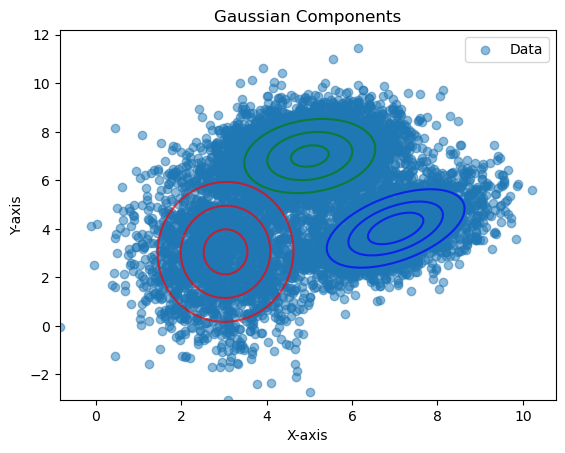

In [53]:

# Run EM algorithm
pi, mean1, cov1, mean2, cov2, mean3, cov3 = run_em(data)

# Print the results
print("Estimated Parameters:")
print("Pi:", pi)
print("Mean 1:", mean1)
print("Covariance 1:")
print(cov1)
print("Mean 2:", mean2)
print("Covariance 2:")
print(cov2)
print("Mean 3:", mean3)
print("Covariance 3:")
print(cov3)

# Plot Gaussian components
plot_gaussian_components(data, mean1, cov1, mean2, cov2, mean3, cov3)

# Problem 1

[Solution for Problem 1 -  KMeans Theory](HW2A-1.pdf)
